# Import

In [1]:
import sys
sys.path.append('../src')

from data_manager import (
    get_image_paths,
    get_images,
    get_labels
)
from pipelines import preprocessing_pipeline
from pipelines import classifier_pipeline

import os
import matplotlib.pyplot as plt
import numpy as np
import random
from tqdm import tqdm 

import cv2
from skimage import io, color, transform, feature
from skimage.feature import hog, local_binary_pattern

from sklearn.base import (
    BaseEstimator, 
    TransformerMixin
)
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (
    train_test_split,
    KFold,
    cross_val_score,
    GridSearchCV,
    RandomizedSearchCV
)
from sklearn.metrics import (
    accuracy_score, 
    classification_report,
    confusion_matrix
)
from sklearn.svm import SVC

root_path = '../'
ck_data_path = os.path.join(root_path, 'data/CK+48')
jaffe_data_path = os.path.join(root_path, 'data/JAFFE')

In [2]:
ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck', verbose=True)
jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe', verbose=True)

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 252.03it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)


100%|██████████| 213/213 [00:00<00:00, 476.06it/s]

Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)


# Handmade LBP

In [128]:
def handmade_lbp(image):                              

    h, w = image.shape
    result = np.zeros_like(image)
    
    kernel_size = 3

    for i in range(h-kernel_size):                 
        for j in range(w-kernel_size):           

            x = image[
                i:i+kernel_size,
                j:j+kernel_size
            ]                   
            center = x[1,1] # center value for 3*3 kernel

            # if neighbouring values of center value is greater than center value -> 1, else 0
            binary_image = (x >= center)*1.0 
            binary_image_vector = binary_image.T.flatten()  
            binary_image_vector = np.delete(binary_image_vector, 4) # remove the center
            digit = np.where(binary_image_vector)[0]         

            if len(digit) >= 1:                     # converting the neighbouring pixels according to center pixel value
                num = np.sum(2**digit)              # if n> center assign 1 and if n<center assign 0
            else:                                    # if 1 then multiply by 2^digit and if 0 then making value 0 and aggregating all the values of kernel to get new center value
                num = 0
            result[i+1,j+1] = num
    return (result)

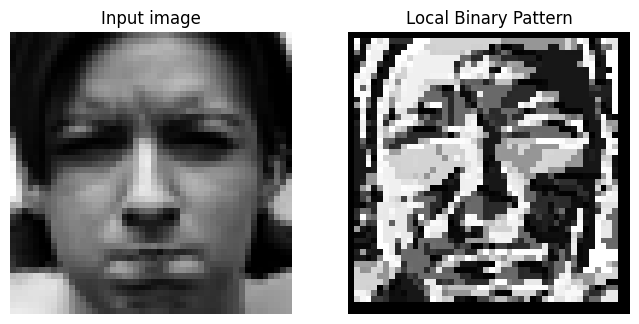

In [129]:
ck_image = ck_images[0]
lbp_ck_image = handmade_lbp(ck_image)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(ck_image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(lbp_ck_image, cmap='gray')
ax2.set_title('Local Binary Pattern')
plt.show()

# ```skimage``` LBP

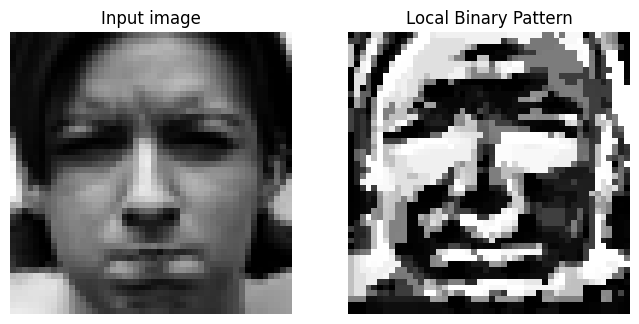

In [3]:
ck_image = ck_images[0]

lbp_ck_image = feature.local_binary_pattern(
    ck_image,
    P=10,
    R=3
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(ck_image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(lbp_ck_image, cmap='gray')
ax2.set_title('Local Binary Pattern')

plt.savefig('ck-lbp.png')
plt.show()

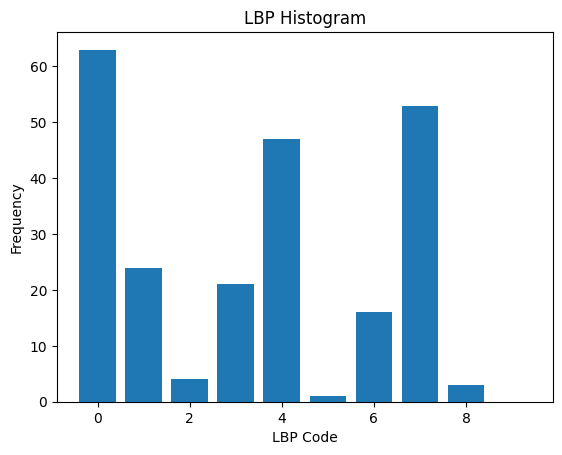

In [14]:
hist, _ = np.histogram(lbp_ck_image.ravel(), bins=np.arange(0, 8 + 3), range=(0, 8 + 2))

# Plot the histogram
plt.bar(range(0, 8 + 2), hist)
plt.title('LBP Histogram')
plt.xlabel('LBP Code')
plt.ylabel('Frequency')
plt.savefig('ck-lbp-features.png')
plt.show()

# Exploration

[[ 0.  3.  2. ...  3.  0.  0.]
 [ 0.  3.  1. ... 25.  0.  0.]
 [25. 25. 25. ... 25.  1.  0.]
 ...
 [ 5.  5. 25. ...  7.  6.  4.]
 [ 1.  0.  0. ...  7.  4.  2.]
 [ 0.  0.  0. ...  6.  4.  2.]]


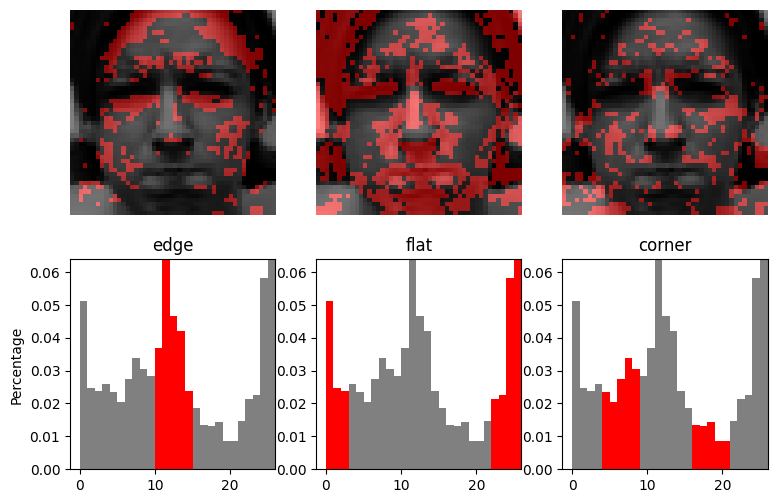

In [42]:
from skimage.transform import rotate
from skimage.feature import local_binary_pattern
from skimage import data
from skimage.color import label2rgb

METHOD = 'uniform'

# settings for LBP
radius = 3
n_points = 8 * radius


def overlay_labels(image, lbp, labels):
    mask = np.logical_or.reduce([lbp == each for each in labels])
    return label2rgb(mask, image=image, bg_label=0, alpha=0.5)


def highlight_bars(bars, indexes):
    for i in indexes:
        bars[i].set_facecolor('r')


# image = ck_images.reshape((ck_images.shape[0], -1))
image= ck_image
lbp = local_binary_pattern(image, n_points, radius, METHOD)
print(lbp)


def hist(ax, lbp):
    n_bins = int(lbp.max() + 1)
    return ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins),
                   facecolor='0.5')


# plot histograms of LBP of textures
fig, (ax_img, ax_hist) = plt.subplots(nrows=2, ncols=3, figsize=(9, 6))
plt.gray()

titles = ('edge', 'flat', 'corner')
w = width = radius - 1
edge_labels = range(n_points // 2 - w, n_points // 2 + w + 1)
flat_labels = list(range(0, w + 1)) + list(range(n_points - w, n_points + 2))
i_14 = n_points // 4            # 1/4th of the histogram
i_34 = 3 * (n_points // 4)      # 3/4th of the histogram
corner_labels = (list(range(i_14 - w, i_14 + w + 1)) +
                 list(range(i_34 - w, i_34 + w + 1)))

label_sets = (edge_labels, flat_labels, corner_labels)

for ax, labels in zip(ax_img, label_sets):
    ax.imshow(overlay_labels(image, lbp, labels))

for ax, labels, name in zip(ax_hist, label_sets, titles):
    counts, _, bars = hist(ax, lbp)
    highlight_bars(bars, labels)
    ax.set_ylim(top=np.max(counts[:-1]))
    ax.set_xlim(right=n_points + 2)
    ax.set_title(name)

ax_hist[0].set_ylabel('Percentage')
for ax in ax_img:
    ax.axis('off')

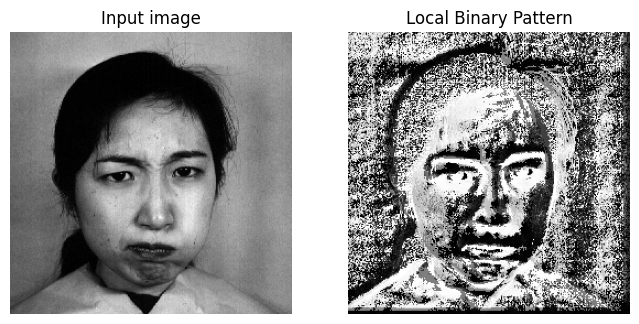

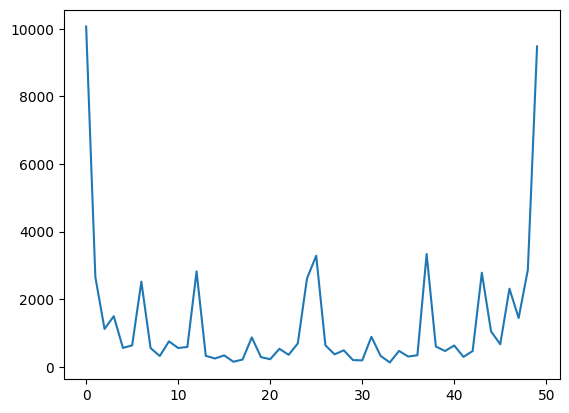

In [5]:
jaffe_image = jaffe_images[1]

lbp_jaffe_image = feature.local_binary_pattern(
    jaffe_image,
    P=12,
    R=6
)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=True, sharey=True)
ax1.axis('off')
ax1.imshow(jaffe_image, cmap='gray')
ax1.set_title('Input image')
ax2.axis('off')
ax2.imshow(lbp_jaffe_image, cmap='gray')
ax2.set_title('Local Binary Pattern')

plt.savefig('jaffe-lbp.png')
plt.show()

n_bins = int(lbp_jaffe_image.max() + 1)
hist, _ = np.histogram(lbp_jaffe_image.ravel(), bins=50)
plt.plot(hist)

plt.savefig('figures/jaffe-lbp-histogram')
plt.show()


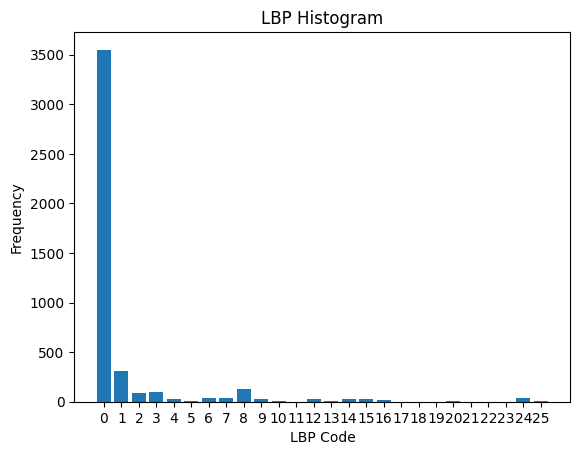

In [18]:
# Calculate histogram of LBP features
n_points=24

hist, _ = np.histogram(lbp_jaffe_image.ravel(), bins=np.arange(0, n_points + 3), range=(0, n_points + 2))

# Plot the histogram
plt.bar(range(n_points + 2), hist)
plt.xticks(range(n_points+2))
plt.title('LBP Histogram')
plt.xlabel('LBP Code')
plt.ylabel('Frequency')
plt.savefig('jaffe-lbp-features.png')
plt.show()

# LBP Pipeline

In [3]:
from pipelines import lbp_pipeline

ck_features = lbp_pipeline(ck_images, block_size=(8,8), P=8, R=1, verbose=True)

lbp_pipeline


100%|██████████| 981/981 [00:13<00:00, 73.54it/s] 

P: 8
R: 1
Features: (981, 1800)


In [4]:
from pipelines import lbp_pipeline

jaffe_features = lbp_pipeline(jaffe_images, block_size=(20,20), P=16, R=2, verbose=True)
jaffe_labels

from pipelines import classifier_pipeline

train_results, test_results = classifier_pipeline(
    jaffe_features,
    jaffe_labels,
    verbose=True
)

lbp_pipeline


100%|██████████| 213/213 [00:21<00:00,  9.82it/s]


P: 16
R: 2
Features: (213, 8450)
Train Result:
Accuracy Score: 73.83%
Test Result:
Accuracy Score: 34.38%


In [36]:
jaffe_features.shape
jaffe_features[0]

array([39, 39,  8, ...,  3,  7, 85], dtype=int64)

# Full pipeline

In [5]:
from pipelines import full_lbp_pipeline

train_results, test_results = full_lbp_pipeline(
    ck_data_path, 
    'ck',
    block_size=(6,6),
    P = 8,
    R = 3,
    test_size = 0.3,
    random_state = 42,
    verbose=True
)



--- PREPROCESSING ---


  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 295.13it/s]


Dataset: ck
Dataset length: 981
Image shape: (48, 48)
--- LBP ---
lbp_pipeline


100%|██████████| 981/981 [00:20<00:00, 47.87it/s]


P: 8
R: 3
Features: (981, 3200)
--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 95.25%


In [6]:
from pipelines import full_lbp_pipeline

train_results, test_results = full_lbp_pipeline(
    jaffe_data_path, 
    'jaffe',
    block_size=(32,32),
    P = 16,
    R = 2,
    test_size = 0.3,
    random_state = 42,
    verbose=True
)

--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 780.00it/s] 


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- LBP ---
lbp_pipeline


100%|██████████| 213/213 [00:17<00:00, 12.51it/s]


P: 16
R: 2
Features: (213, 3200)
--- CLASSIF ---


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Train Result:
Accuracy Score: 38.26%
Test Result:
Accuracy Score: 20.31%


c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CrossVal

In [28]:
from pipelines import LBPTransformer

ck_images, ck_labels = preprocessing_pipeline(ck_data_path, 'ck')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

lbp_sk_pipeline = Pipeline([
    ('lbp_features', LBPTransformer(block_size=(6,6), P=10, R=3)),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(lbp_sk_pipeline, ck_images, ck_labels, scoring='accuracy', cv=cv, n_jobs=-1, verbose=3)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 981/981 [00:03<00:00, 300.45it/s]
# SVM MEAN  Accuracy:  95.61%
# Standard deviation:  0.608%

  0%|          | 0/981 [00:00<?, ?it/s]

100%|██████████| 981/981 [00:03<00:00, 250.32it/s]
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


SVM MEAN  Accuracy:  95.61%
Standard deviation:  0.608%


[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed:   44.4s finished


In [22]:
from pipelines import LBPTransformer

ck_images, ck_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

lbp_sk_pipeline = Pipeline([
    ('lbp_features', LBPTransformer(block_size=(16,16), P=12, R=6)),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(lbp_sk_pipeline, jaffe_images, jaffe_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

100%|██████████| 213/213 [00:00<00:00, 953.24it/s]


SVM MEAN  Accuracy:  78.41%
Standard deviation:  2.721%


# Gridsearch

In [40]:
X_train, X_test, y_train, y_test = train_test_split(
    *preprocessing_pipeline(jaffe_data_path, 'jaffe'),
    test_size=0.25, random_state=42, shuffle=True
)

100%|██████████| 213/213 [00:00<00:00, 841.47it/s]


In [41]:
from pipelines import LBPTransformer

lbp_sk_pipeline = Pipeline([
    ('lbp_features', LBPTransformer(
        block_size=(32,32), 
        P=3, 
        R=1
    )),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

param_grid = {
    'lbp_features__block_size': [(16,16), (32,32)],
    'lbp_features__P': [8, 16],
    'lbp_features__R': [1, 3, 5, 10]
}

grid_search = GridSearchCV(
    estimator=lbp_sk_pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=4,
    verbose=3
)

grid_search.fit(X_train, y_train)
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_
print("Best parameters found by grid search:")
print(best_params)


y_train_pred = best_estimator.predict(X_train)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_train, y_train_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_train, y_train_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_train, y_train_pred)}")


y_test_pred = best_estimator.predict(X_test)
print("\nTest Result:\n================================================")
print(f"Accuracy Score: {accuracy_score(y_test, y_test_pred) * 100:.2f}%")
print("_______________________________________________")
print(f"CLASSIFICATION REPORT:\n{classification_report(y_test, y_test_pred)}")
print("_______________________________________________")
print(f"Confusion Matrix: \n{confusion_matrix(y_test, y_test_pred)}")


# Best parameters found by grid search:
# {'lbp_features__P': 16, 'lbp_features__R': 3}
#   0%|          | 0/159 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
#   warnings.warn(
# 100%|██████████| 159/159 [00:01<00:00, 126.63it/s]

# Test Result:
# ================================================
# Accuracy Score: 100.00%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        21
#      Disgust       1.00      1.00      1.00        25
#         Fear       1.00      1.00      1.00        22
#    Happiness       1.00      1.00      1.00        23
#      Neutral       1.00      1.00      1.00        21
#      Sadness       1.00      1.00      1.00        26
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           1.00       159
#    macro avg       1.00      1.00      1.00       159
# weighted avg       1.00      1.00      1.00       159

# _______________________________________________
# Confusion Matrix: 
# [[21  0  0  0  0  0  0]
#  [ 0 25  0  0  0  0  0]
#  [ 0  0 22  0  0  0  0]
#  [ 0  0  0 23  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  0  0 26  0]
#  [ 0  0  0  0  0  0 21]]
#   0%|          | 0/54 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
#   warnings.warn(
# 100%|██████████| 54/54 [00:00<00:00, 141.60it/s]

# Test Result:
# ================================================
# Accuracy Score: 85.19%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       0.86      0.67      0.75         9
#      Disgust       0.60      0.75      0.67         4
#         Fear       0.89      0.80      0.84        10
#    Happiness       1.00      1.00      1.00         8
#      Neutral       0.90      1.00      0.95         9
#      Sadness       0.71      1.00      0.83         5
#     Surprise       0.88      0.78      0.82         9

#     accuracy                           0.85        54
#    macro avg       0.83      0.86      0.84        54
# weighted avg       0.86      0.85      0.85        54

# _______________________________________________
# Confusion Matrix: 
# [[6 2 1 0 0 0 0]
#  [1 3 0 0 0 0 0]
#  [0 0 8 0 0 1 1]
#  [0 0 0 8 0 0 0]
#  [0 0 0 0 9 0 0]
#  [0 0 0 0 0 5 0]
#  [0 0 0 0 1 1 7]]


# Best parameters found by grid search:
# {'lbp_features__P': 8, 'lbp_features__R': 5, 'lbp_features__block_size': (16, 16)}
# 100%|██████████| 159/159 [00:22<00:00,  6.95it/s]

# Test Result:
# ================================================
# Accuracy Score: 98.74%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       1.00      1.00      1.00        21
#      Disgust       1.00      1.00      1.00        25
#         Fear       1.00      0.95      0.98        22
#    Happiness       0.96      1.00      0.98        23
#      Neutral       1.00      1.00      1.00        21
#      Sadness       0.96      0.96      0.96        26
#     Surprise       1.00      1.00      1.00        21

#     accuracy                           0.99       159
#    macro avg       0.99      0.99      0.99       159
# weighted avg       0.99      0.99      0.99       159

# _______________________________________________
# Confusion Matrix: 
# [[21  0  0  0  0  0  0]
#  [ 0 25  0  0  0  0  0]
#  [ 0  0 21  0  0  1  0]
#  [ 0  0  0 23  0  0  0]
#  [ 0  0  0  0 21  0  0]
#  [ 0  0  0  1  0 25  0]
#  [ 0  0  0  0  0  0 21]]
# 100%|██████████| 54/54 [00:08<00:00,  6.71it/s]

# Test Result:
# ================================================
# Accuracy Score: 75.93%
# _______________________________________________
# CLASSIFICATION REPORT:
#               precision    recall  f1-score   support

#        Anger       0.88      0.78      0.82         9
#      Disgust       0.43      0.75      0.55         4
#         Fear       0.75      0.60      0.67        10
#    Happiness       0.89      1.00      0.94         8
#      Neutral       0.89      0.89      0.89         9
#      Sadness       0.62      1.00      0.77         5
#     Surprise       0.80      0.44      0.57         9

#     accuracy                           0.76        54
#    macro avg       0.75      0.78      0.74        54
# weighted avg       0.79      0.76      0.76        54

# _______________________________________________
# Confusion Matrix: 
# [[7 2 0 0 0 0 0]
#  [1 3 0 0 0 0 0]
#  [0 2 6 0 1 0 1]
#  [0 0 0 8 0 0 0]
#  [0 0 0 1 8 0 0]
#  [0 0 0 0 0 5 0]
#  [0 0 2 0 0 3 4]]

Fitting 4 folds for each of 16 candidates, totalling 64 fits


100%|██████████| 40/40 [00:02<00:00, 15.85it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.325 total time=  15.4s


100%|██████████| 40/40 [00:04<00:00,  9.04it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.275 total time=  19.0s


100%|██████████| 40/40 [00:05<00:00,  7.22it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.425 total time=  20.3s


100%|██████████| 39/39 [00:02<00:00, 15.44it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.436 total time=  16.5s


100%|██████████| 40/40 [00:01<00:00, 26.19it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.225 total time=   6.1s


100%|██████████| 40/40 [00:01<00:00, 27.19it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.250 total time=   5.8s


100%|██████████| 40/40 [00:01<00:00, 26.50it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.200 total time=   5.9s


100%|██████████| 39/39 [00:01<00:00, 26.02it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.205 total time=   5.7s


100%|██████████| 40/40 [00:02<00:00, 17.40it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.600 total time=  12.4s


100%|██████████| 40/40 [00:02<00:00, 15.86it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.425 total time=  12.1s


100%|██████████| 40/40 [00:02<00:00, 15.83it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.575 total time=  12.5s


100%|██████████| 39/39 [00:02<00:00, 15.12it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.641 total time=  12.3s


100%|██████████| 40/40 [00:01<00:00, 27.37it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.275 total time=   5.9s


100%|██████████| 40/40 [00:01<00:00, 28.09it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.275 total time=   5.9s


100%|██████████| 40/40 [00:01<00:00, 26.10it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.200 total time=   5.9s


100%|██████████| 39/39 [00:01<00:00, 25.89it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.385 total time=   6.0s


100%|██████████| 40/40 [00:02<00:00, 17.18it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.700 total time=  11.9s


100%|██████████| 40/40 [00:02<00:00, 15.43it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.575 total time=  12.5s


100%|██████████| 40/40 [00:02<00:00, 15.15it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.675 total time=  12.6s


100%|██████████| 39/39 [00:02<00:00, 16.92it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.821 total time=  12.0s


100%|██████████| 40/40 [00:01<00:00, 25.97it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.375 total time=   5.6s


100%|██████████| 40/40 [00:01<00:00, 27.43it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.275 total time=   5.9s


100%|██████████| 40/40 [00:01<00:00, 27.01it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.400 total time=   5.7s


100%|██████████| 39/39 [00:01<00:00, 27.30it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.410 total time=   5.8s


100%|██████████| 40/40 [00:02<00:00, 15.58it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.225 total time=  12.4s


100%|██████████| 40/40 [00:02<00:00, 16.37it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.275 total time=  11.8s


100%|██████████| 40/40 [00:02<00:00, 16.52it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.300 total time=  11.9s


100%|██████████| 39/39 [00:02<00:00, 16.86it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.231 total time=  11.8s


100%|██████████| 40/40 [00:01<00:00, 30.32it/s]


[CV 1/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.500 total time=   5.4s


100%|██████████| 40/40 [00:01<00:00, 25.26it/s]


[CV 2/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.450 total time=   6.0s


100%|██████████| 40/40 [00:01<00:00, 24.28it/s]


[CV 3/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.450 total time=   5.7s


100%|██████████| 39/39 [00:01<00:00, 29.49it/s]


[CV 4/4] END lbp_features__P=8, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.641 total time=   5.4s


100%|██████████| 40/40 [00:03<00:00, 11.13it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.375 total time=  16.7s


100%|██████████| 40/40 [00:03<00:00, 11.45it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.350 total time=  16.6s


100%|██████████| 40/40 [00:03<00:00, 11.48it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.400 total time=  16.9s


100%|██████████| 39/39 [00:03<00:00, 11.03it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(16, 16);, score=0.487 total time=  16.1s


100%|██████████| 40/40 [00:02<00:00, 15.57it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.200 total time=   9.7s


100%|██████████| 40/40 [00:02<00:00, 17.60it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.250 total time=   9.6s


100%|██████████| 40/40 [00:02<00:00, 15.87it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.225 total time=   9.5s


100%|██████████| 39/39 [00:02<00:00, 16.07it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=1, lbp_features__block_size=(32, 32);, score=0.256 total time=  10.0s


100%|██████████| 40/40 [00:03<00:00, 11.87it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.425 total time=  16.7s


100%|██████████| 40/40 [00:03<00:00, 10.95it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.300 total time=  16.5s


100%|██████████| 40/40 [00:03<00:00, 11.53it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.325 total time=  16.1s


100%|██████████| 39/39 [00:01<00:00, 21.50it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(16, 16);, score=0.436 total time=  12.3s


100%|██████████| 40/40 [00:03<00:00, 10.82it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.175 total time=  10.8s


100%|██████████| 40/40 [00:02<00:00, 17.39it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.175 total time=   9.4s


100%|██████████| 40/40 [00:02<00:00, 17.09it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.225 total time=   9.8s


100%|██████████| 39/39 [00:04<00:00,  8.55it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=3, lbp_features__block_size=(32, 32);, score=0.154 total time=  14.2s


100%|██████████| 40/40 [00:06<00:00,  5.98it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.725 total time=  32.9s


100%|██████████| 40/40 [00:06<00:00,  5.89it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.525 total time=  32.7s


100%|██████████| 40/40 [00:06<00:00,  5.99it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.575 total time=  31.6s


100%|██████████| 39/39 [00:06<00:00,  5.61it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(16, 16);, score=0.769 total time=  33.6s


100%|██████████| 40/40 [00:04<00:00,  8.48it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.300 total time=  18.2s


100%|██████████| 40/40 [00:02<00:00, 14.67it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.250 total time=  16.3s


100%|██████████| 40/40 [00:02<00:00, 13.99it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.250 total time=  11.2s


100%|██████████| 39/39 [00:02<00:00, 18.89it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=5, lbp_features__block_size=(32, 32);, score=0.308 total time=  12.2s


100%|██████████| 40/40 [00:07<00:00,  5.51it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.600 total time=  35.2s


100%|██████████| 40/40 [00:03<00:00, 11.10it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.500 total time=  25.3s


100%|██████████| 40/40 [00:03<00:00, 11.11it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.575 total time=  18.2s


100%|██████████| 39/39 [00:03<00:00,  9.83it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(16, 16);, score=0.718 total time=  19.9s


100%|██████████| 40/40 [00:02<00:00, 15.02it/s]


[CV 1/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.475 total time=  12.2s


100%|██████████| 40/40 [00:02<00:00, 18.49it/s]


[CV 2/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.450 total time=  12.7s


100%|██████████| 40/40 [00:05<00:00,  7.89it/s]


[CV 3/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.425 total time=  15.4s


100%|██████████| 39/39 [00:04<00:00,  8.32it/s]


[CV 4/4] END lbp_features__P=16, lbp_features__R=10, lbp_features__block_size=(32, 32);, score=0.564 total time=  14.8s


100%|██████████| 159/159 [00:23<00:00,  6.88it/s]


Best parameters found by grid search:
{'lbp_features__P': 8, 'lbp_features__R': 5, 'lbp_features__block_size': (16, 16)}


100%|██████████| 159/159 [00:22<00:00,  6.95it/s]



Test Result:
Accuracy Score: 98.74%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Anger       1.00      1.00      1.00        21
     Disgust       1.00      1.00      1.00        25
        Fear       1.00      0.95      0.98        22
   Happiness       0.96      1.00      0.98        23
     Neutral       1.00      1.00      1.00        21
     Sadness       0.96      0.96      0.96        26
    Surprise       1.00      1.00      1.00        21

    accuracy                           0.99       159
   macro avg       0.99      0.99      0.99       159
weighted avg       0.99      0.99      0.99       159

_______________________________________________
Confusion Matrix: 
[[21  0  0  0  0  0  0]
 [ 0 25  0  0  0  0  0]
 [ 0  0 21  0  0  1  0]
 [ 0  0  0 23  0  0  0]
 [ 0  0  0  0 21  0  0]
 [ 0  0  0  1  0 25  0]
 [ 0  0  0  0  0  0 21]]


100%|██████████| 54/54 [00:08<00:00,  6.71it/s]



Test Result:
Accuracy Score: 75.93%
_______________________________________________
CLASSIFICATION REPORT:
              precision    recall  f1-score   support

       Anger       0.88      0.78      0.82         9
     Disgust       0.43      0.75      0.55         4
        Fear       0.75      0.60      0.67        10
   Happiness       0.89      1.00      0.94         8
     Neutral       0.89      0.89      0.89         9
     Sadness       0.62      1.00      0.77         5
    Surprise       0.80      0.44      0.57         9

    accuracy                           0.76        54
   macro avg       0.75      0.78      0.74        54
weighted avg       0.79      0.76      0.76        54

_______________________________________________
Confusion Matrix: 
[[7 2 0 0 0 0 0]
 [1 3 0 0 0 0 0]
 [0 2 6 0 1 0 1]
 [0 0 0 8 0 0 0]
 [0 0 0 1 8 0 0]
 [0 0 0 0 0 5 0]
 [0 0 2 0 0 3 4]]


##### pipeline

In [117]:
def full_lbp_pipeline(
    data_path, 
    dataset,
    P = 8,
    R = 3,
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    verbose=False
):
    
    print('--- PREPROCESSING ---')
    images, labels = preprocessing_pipeline(
        data_path=data_path,
        dataset=dataset, 
        verbose=verbose
    ) 

    print('--- LBP ---')
    features = lbp_pipeline(
        images=images, 
        P=P, 
        R=R, 
        resize=resize,
        verbose=verbose
    )
    
    print('--- CLASSIF ---')
    train_results, test_results = classifier_pipeline(
        features=features,
        labels=labels,
        verbose=verbose
    )

    return train_results, test_results


In [19]:
train_results, test_results = full_lbp_pipeline(
    jaffe_data_path, 
    'jaffe',
    P = 16,
    R = 3,
    resize = (32,32),
    test_size = 0.3,
    random_state = 42,
    verbose=True
)

--- PREPROCESSING ---


100%|██████████| 213/213 [00:00<00:00, 854.59it/s]


Dataset: jaffe
Dataset length: 213
Image shape: (256, 256)
--- LBP ---


  0%|          | 0/213 [00:00<?, ?it/s]c:\Users\alexa\AppData\Local\Programs\Python\Python311\Lib\site-packages\skimage\feature\texture.py:353: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(
100%|██████████| 213/213 [00:01<00:00, 114.84it/s]


P: 16
R: 3
Features: (213, 1024)
--- CLASSIF ---
Train Result:
Accuracy Score: 100.00%
Test Result:
Accuracy Score: 85.94%


##### cross-val

In [31]:
from pipelines import LBPTransformer

jaffe_images, jaffe_labels = preprocessing_pipeline(jaffe_data_path, 'jaffe')

cv = KFold(n_splits=4, random_state=42, shuffle=True)

lbp_sk_pipeline = Pipeline([
    ('lbp_features', LBPTransformer(P=8, R=3, resize=(32,32))),
    ('svc', SVC(kernel='rbf', gamma='scale', C= 10))
])

scores = cross_val_score(lbp_sk_pipeline, jaffe_images, jaffe_labels, scoring='accuracy', cv=cv, n_jobs=-1)
print('SVM MEAN  Accuracy: ',str(np.mean(scores)*100)[:5] + '%')
print('Standard deviation: ',str(np.std(scores)*100)[:5] + '%')

# 100%|██████████| 213/213 [00:00<00:00, 897.45it/s]
# SVM MEAN  Accuracy:  80.26%
# Standard deviation:  2.216%

100%|██████████| 213/213 [00:00<00:00, 1043.91it/s]


SVM MEAN  Accuracy:  80.26%
Standard deviation:  2.216%
